In [1]:
import numpy as np
import torch
from torch import nn
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from funciones import train_model, visualize_true_vs_pred_regression, plot_history, grafico_pasos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data= np.load('Datos/Transformados/montecarlo_data.npz')
features = data['features']
target = data['target']

In [3]:
bbva_palette = ['#004481',
                '#1586AF',
                '#08DAE9']

c:\Users\Admin\.conda\envs\DM_reto09\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


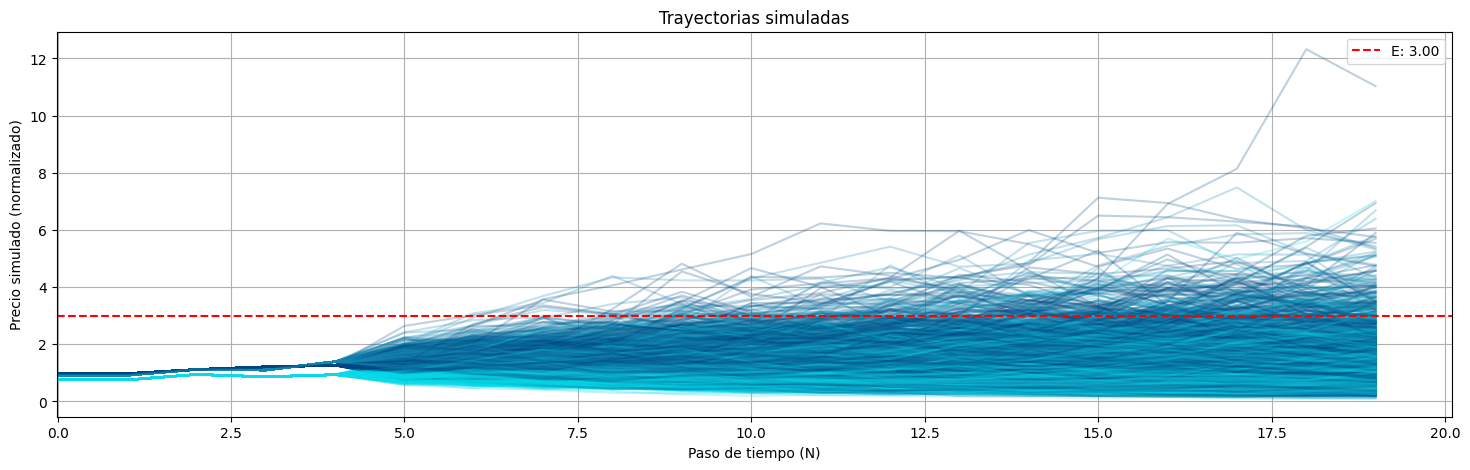

In [4]:
plt.figure(figsize=(18, 5))
for i in range(1000):
    for j in range(features.shape[2]): # plotea 20 trayectorias aleatorias del activo 1
        plt.plot(features[i, :, j], alpha=0.25, color = bbva_palette[j])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()



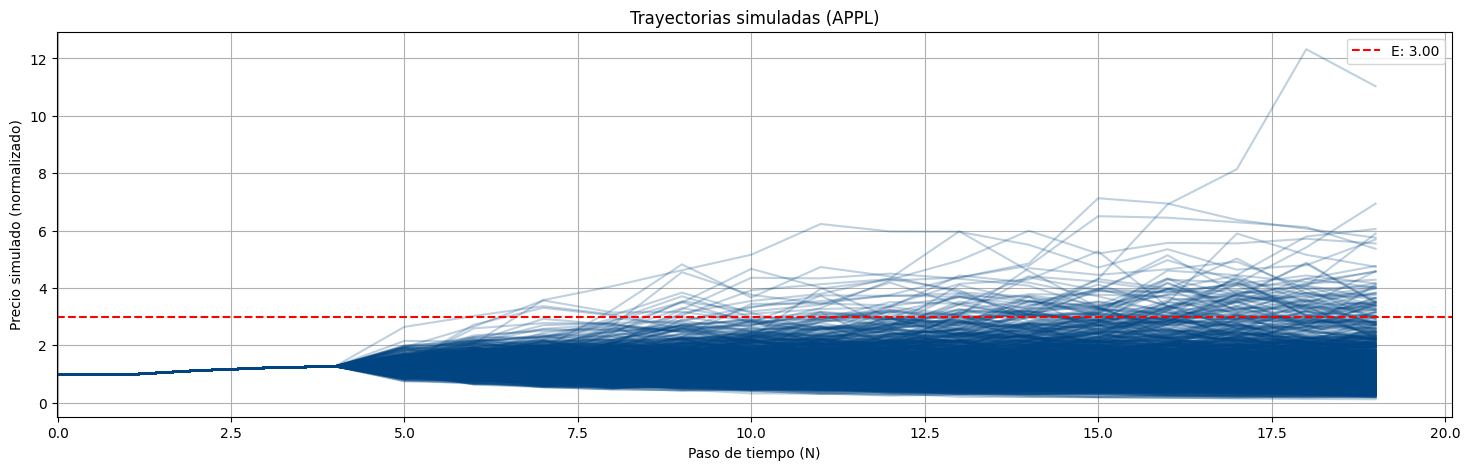

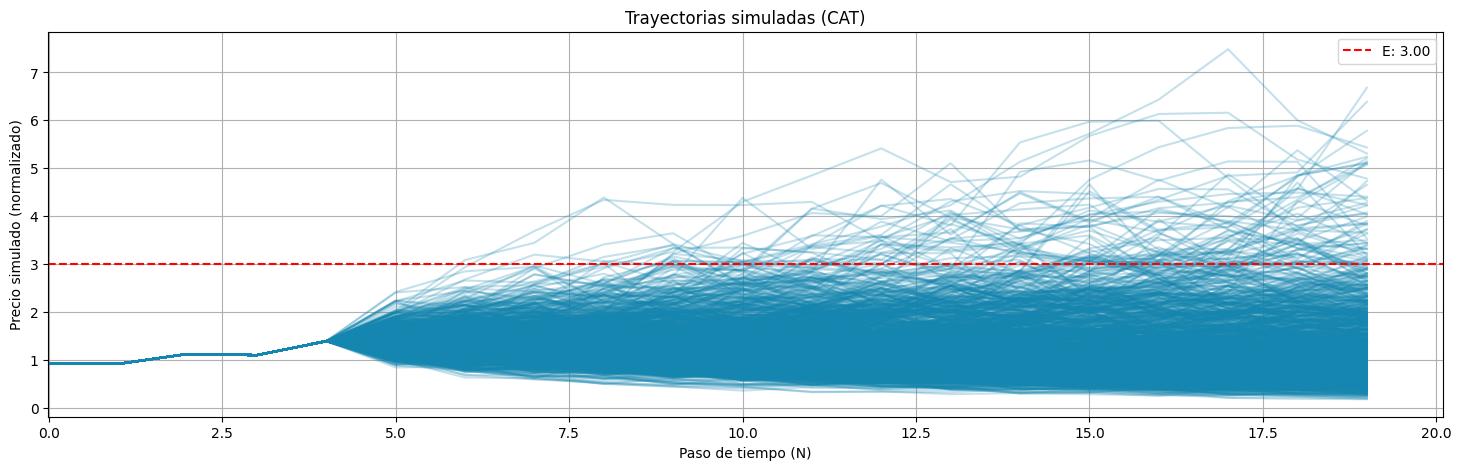

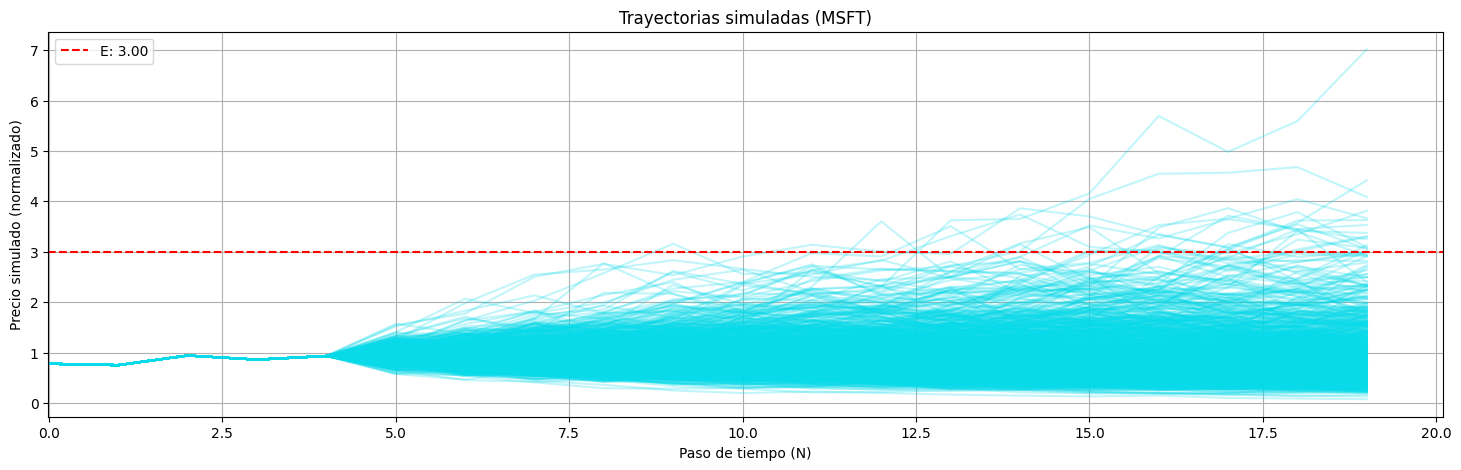

In [5]:
plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 0], alpha=0.25, color = bbva_palette[0])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (APPL)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 1], alpha=0.25, color = bbva_palette[1])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (CAT)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 5))
for i in range(1000):
    plt.plot(features[i, :, 2], alpha=0.25, color = bbva_palette[2])
plt.axhline(y=3, color='red', linestyle='--', label = f'E: {3:.2f}')
plt.title("Trayectorias simuladas (MSFT)")
plt.xlabel("Paso de tiempo (N)")
plt.ylabel("Precio simulado (normalizado)")
plt.xlim(-0.01,20.1)
plt.legend()
plt.grid(True)
plt.show()

### CREACIÓN DE LOADERS

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=42,
    shuffle=True 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42,
    shuffle=True  
)

print(f"Features de Train:  {X_train.shape}")   
print(f"Targets de Train:   {y_train.shape}")
print(f"Features de validation:  {X_val.shape}") 
print(f"Targets de validation:   {y_val.shape}")
print(f"Features de test:  {X_test.shape}") 
print(f"Targets de test:   {y_test.shape}")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))


batch_size = 64 
train_dataloader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True) 


val_dataloader = DataLoader(dataset=val_dataset, 
                          batch_size=batch_size, 
                          shuffle=False) 

test_dataloader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False) 


Features de Train:  (60000, 20, 3)
Targets de Train:   (60000,)
Features de validation:  (20000, 20, 3)
Targets de validation:   (20000,)
Features de test:  (20000, 20, 3)
Targets de test:   (20000,)


### CREACIÓN DE CLASES: MODELO Y EARLY STOPPER

In [7]:
import torch
import torch.nn as nn

class GRUmodel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, dropout=0.4):
        super(GRUmodel, self).__init__()
        # Capa GRU
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # Capa fully connected para salida escalar
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()  # Para asegurar salida >= 0

    def forward(self, x):
        """
        x: tensor de forma (batch_size, pasos_temporales, input_dim)
        """
        out, _ = self.gru(x)        
        out = out[:, -1, :]         
        out = self.fc(out)     
        out = self.relu(out)
        return out


In [8]:
import torch
import torch.nn as nn

class LSTMmodel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMmodel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()              

    def forward(self, x):
        """
        x: tensor de forma (batch_size, pasos_temporales, input_dim)
        """
        out, _ = self.lstm(x)           
        out = out[:, -1, :]             
        out = self.fc(out)              
        out = self.relu(out)  
        return out


In [9]:
class EarlyStopper: 
    def __init__(self, patience=1, min_delta=0,save_path = "./best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss,model):
        """Returns whether the training should stop or not. If stopping criterion is not met returns False."""
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### CARGAS DE MODELOS LSTM Y GRU

El entrenamiento de distintos modelos LSTm y GRU, se han realizado en el script de mlflow, en el que se prueban 32 modelos LSTM, y 16 modelos GRU, y de todos ellos se selecciona el mejor de cada uno. ***model27.pt*** se refiere al modelo LSTM, y ***model_gru3.pt*** al GRU. A continuación se va a realizar la comparación entre los dos, y se determinará cual sera el modelo elegido.

In [10]:
# Hiperparametros del mejor modelo LSTM
dropout = 0.4
hidden_size = 64
lr = 0.001
num_layers = 2
gamma= 0.95
clip_value=1
epochs=50
patience=5
min_delta=0
path_lstm = 'Modelos/model27.pt'

In [11]:
model_lstm = LSTMmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model_lstm.load_state_dict(torch.load(path_lstm))
summary(model_lstm)

Layer (type:depth-idx)                   Param #
LSTMmodel                                --
├─LSTM: 1-1                              50,944
├─Linear: 1-2                            65
├─ReLU: 1-3                              --
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0

In [12]:
model_lstm.eval()
with torch.no_grad():
        X_test_t = torch.tensor(X_test, dtype=torch.float)
       
        t_preds_lstm = model_lstm(X_test_t).cpu().detach().numpy().squeeze()
       
        
        MAE_lstm = mean_absolute_error(y_test, t_preds_lstm)
        MSE_lstm = mean_squared_error(y_test, t_preds_lstm)
        r2_lstm = r2_score(y_test, t_preds_lstm)
            

print(f'MAE: {MAE_lstm:.8f}')
print(f'MSE: {MSE_lstm:.8f}')
print(f'R2: {r2_lstm:.8f}')
            

MAE: 0.00132026
MSE: 0.00000496
R2: 0.99983734


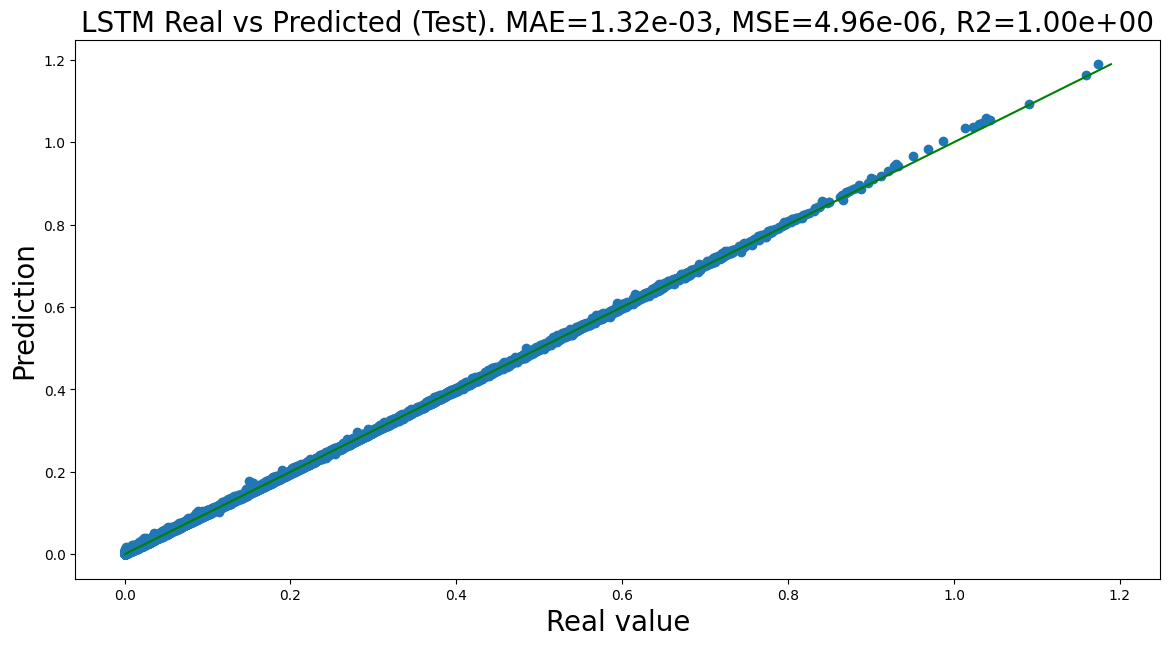

In [13]:
visualize_true_vs_pred_regression(y_test, t_preds_lstm, model='LSTM')

In [14]:
mses_lstm = []
criterion = nn.MSELoss()
pasos_totales = X_test.shape[1] 
pasos = list(range(pasos_totales, 0, -1))

y_test_tensor = torch.tensor(y_test, dtype=torch.float).squeeze()

for i in range(pasos_totales, 0, -1):
    datos = X_test[:, -i:, :]
    model_lstm.eval()

    with torch.no_grad():
        test = torch.tensor(datos, dtype=torch.float)
        pred = model_lstm(test)
        pred = pred.squeeze() 
        
    mse_loss = criterion(pred, y_test_tensor)
    mses_lstm.append(mse_loss.item())

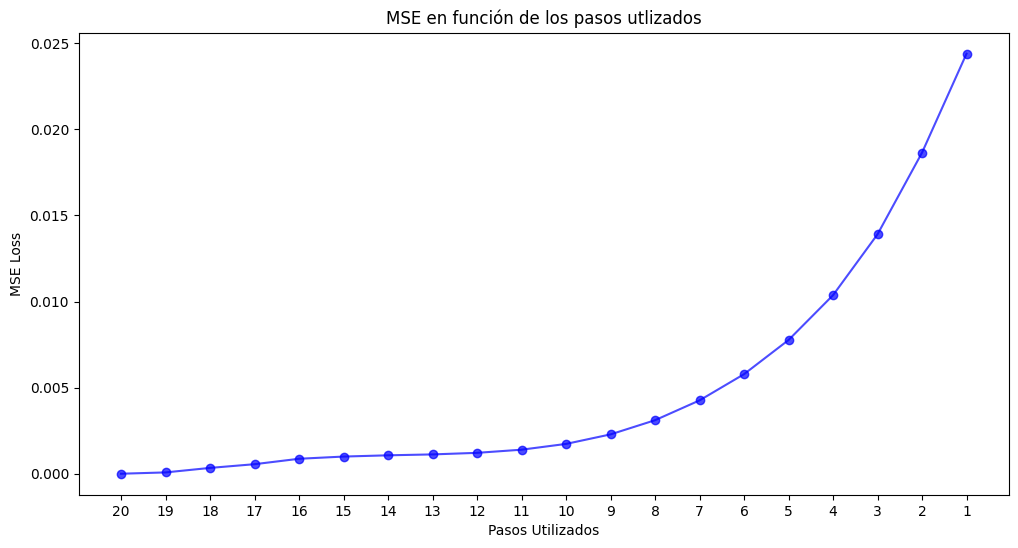

In [15]:
grafico_pasos(pasos, mses_lstm)

In [16]:
# model_lstm.eval()
# rf = 0.01
# media_payoffs_lstm = model_lstm(torch.tensor(features, dtype=torch.float32)).detach().numpy().mean()
# media_payoffs_lstm

In [17]:
# actualizacion = np.exp(-(rf)*5)
# prima_lstm = actualizacion * media_payoffs_lstm
# print(f'Media de Payoffs: {media_payoffs_lstm}')
# print(f'Prima actualizada al valor presente (Modelo LSTM): {prima_lstm}')

Este gráfico demuestra cómo el MSE en la predicción de payoffs permanece estable y muy bajo al usar entre 20 y 13 pasos de simulación, pero se dispara exponencialmente al usar menos de 11, sirviendo para encontrar el equilibrio óptimo entre velocidad de cómputo y precisión del modelo.

#### GRU

In [18]:
dropout = 0.2
hidden_size = 64
lr = 0.001
num_layers = 2
gamma= 0.95
clip_value=1
epochs=50
patience=5
min_delta=0
path_gru = 'Modelos/model_gru3.pt'

In [19]:
model_gru = GRUmodel(input_dim = 3, hidden_dim= hidden_size, num_layers=num_layers, dropout=dropout)
model_gru.load_state_dict(torch.load(path_gru))
summary(model_gru)

Layer (type:depth-idx)                   Param #
GRUmodel                                 --
├─GRU: 1-1                               38,208
├─Linear: 1-2                            65
├─ReLU: 1-3                              --
Total params: 38,273
Trainable params: 38,273
Non-trainable params: 0

In [20]:
model_gru.eval()
with torch.no_grad():
        X_test_t = torch.tensor(X_test, dtype=torch.float)
       
        t_preds_gru = model_gru(X_test_t).cpu().detach().numpy().squeeze()
       
        
        MAE_gru = mean_absolute_error(y_test, t_preds_gru)
        MSE_gru = mean_squared_error(y_test, t_preds_gru)
        r2_gru = r2_score(y_test, t_preds_gru)
            

print(f'MAE: {MAE_gru:.8f}')
print(f'MSE: {MSE_gru:.8f}')
print(f'R2: {r2_gru:.8f}')

MAE: 0.00098701
MSE: 0.00000273
R2: 0.99991060


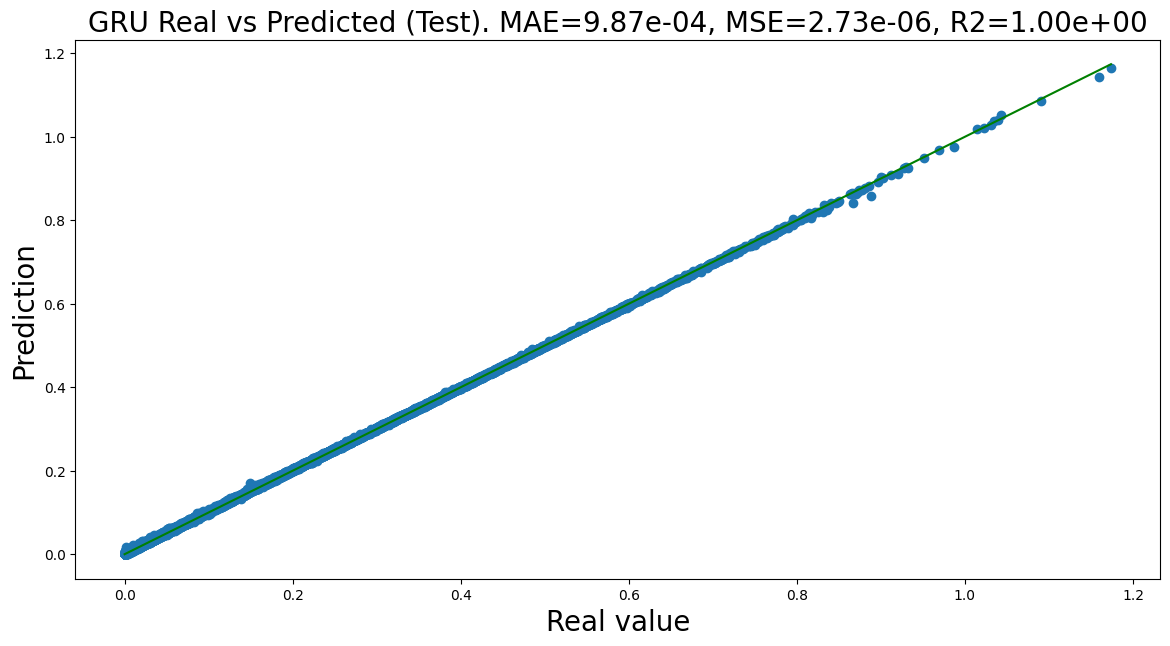

In [21]:
visualize_true_vs_pred_regression(y_test, t_preds_gru, model='GRU')

In [22]:
mses_gru = []
criterion = nn.MSELoss()
pasos_totales = X_test.shape[1] 
pasos = list(range(pasos_totales, 0, -1))

y_test_tensor = torch.tensor(y_test, dtype=torch.float).squeeze()

for i in range(pasos_totales, 0, -1):
    datos = X_test[:, -i:, :]
    model_gru.eval()

    with torch.no_grad():
        test = torch.tensor(datos, dtype=torch.float)
        pred = model_gru(test)
        pred = pred.squeeze() 
        
    mse_loss = criterion(pred, y_test_tensor)
    mses_gru.append(mse_loss.item())



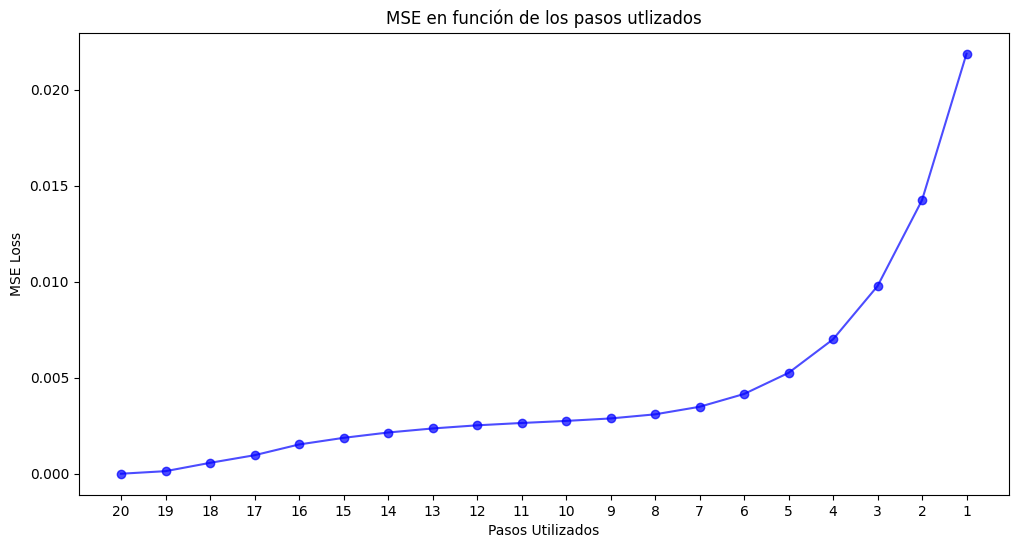

In [23]:
grafico_pasos(pasos, mses_gru)

In [30]:
metrics = pd.DataFrame({'model': ['LSTM', 'GRU'],
                        'MAE': [MAE_lstm, MAE_gru],
                        'MSE': [MSE_lstm, MSE_gru],
                        'R2': [r2_lstm, r2_gru]})
print(metrics)

  model       MAE       MSE        R2
0  LSTM  0.001320  0.000005  0.999837
1   GRU  0.000987  0.000003  0.999911


In [ ]:
model_gru.eval()
rf = 0.01
media_payoffs = model_gru(torch.tensor(features, dtype=torch.float)).detach().numpy().mean()

actualizacion = np.exp(-(rf)*5)
prima = actualizacion * media_payoffs
print(f'Media de Payoffs: {media_payoffs}')
print(f'Prima actualizada al valor presente: {prima}')

0.14044634

Media de Payoffs: 0.14044633507728577
Prima actualizada al valor presente: 0.133596686488801
